## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


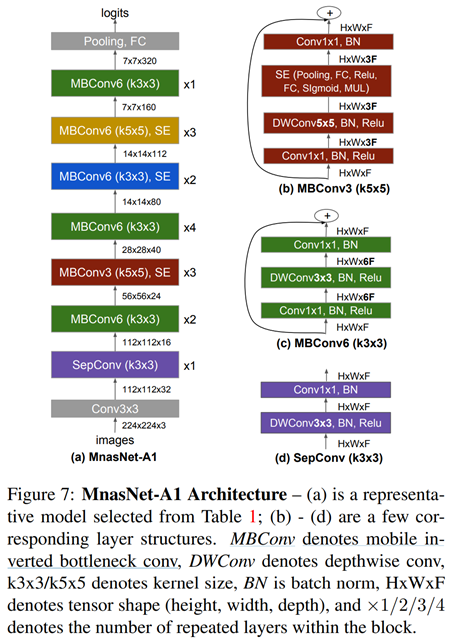

### Download datasets and create dataloaders

In [1]:
#Import all the packages

import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                 std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

cf10_transforms = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train = CIFAR10(root='./data', train=True, download=True, transform=cf10_transforms)
test = CIFAR10(root='./data', train=False, download=True, transform=cf10_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [3]:
torch.manual_seed(42)
val_size = 5000
train_size = len(train) - val_size

In [4]:
train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [5]:
batch_size=64

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 32, 32])


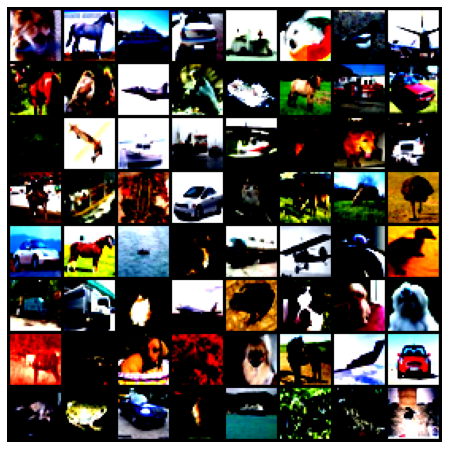

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## Your codes go here:
### (1) Define the model

In [7]:
#Import all the packages
import torch
from torch import nn

import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D
#!pip install .utils
import warnings
from torch import Tensor
import torch.nn as nn
#from .utils import load_state_dict_from_url
from typing import Any, Dict, List

!pip install matplotlib
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [8]:
#Reference: 
#https://www.machinecurve.com/index.php/2019/09/24/creating-depthwise-separable-convolutions-in-keras/
#https://amaarora.github.io/2020/07/24/SeNet.html
#https://pytorch.org/vision/stable/_modules/torchvision/models/mnasnet.html
#https://faroit.com/keras-docs/0.3.3/models/

_BN_MOMENTUM = 1 - 0.9997
class _InvertedResidual(nn.Module):

    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        kernel_size: int,
        stride: int,
        expansion_factor: int,
        bn_momentum: float = 0.1
    ) -> None:
        super(_InvertedResidual, self).__init__()
        assert stride in [1, 2]
        assert kernel_size in [3, 5]
        mid_ch = in_ch * expansion_factor
        self.apply_residual = (in_ch == out_ch and stride == 1)
        self.layers = nn.Sequential(
            # Pointwise
            nn.Conv2d(in_ch, mid_ch, 1, bias=False),
            nn.BatchNorm2d(mid_ch, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            # Depthwise
            nn.Conv2d(mid_ch, mid_ch, kernel_size, padding=kernel_size // 2,
                      stride=stride, groups=mid_ch, bias=False),
            nn.BatchNorm2d(mid_ch, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            # Linear pointwise. Note that there's no activation.
            nn.Conv2d(mid_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch, momentum=bn_momentum))

    def forward(self, input: Tensor) -> Tensor:
        if self.apply_residual:
            return self.layers(input) + input
        else:
            return self.layers(input)


def _stack(in_ch: int, out_ch: int, kernel_size: int, stride: int, exp_factor: int, repeats: int,
           bn_momentum: float) -> nn.Sequential:
    """ Creates a stack of inverted residuals. """
    assert repeats >= 1
    # First one has no skip, because feature map size changes.
    first = _InvertedResidual(in_ch, out_ch, kernel_size, stride, exp_factor,
                              bn_momentum=bn_momentum)
    remaining = []
    for _ in range(1, repeats):
        remaining.append(
            _InvertedResidual(out_ch, out_ch, kernel_size, 1, exp_factor,
                              bn_momentum=bn_momentum))
    return nn.Sequential(first, *remaining)

def _round_to_multiple_of(val: float, divisor: int, round_up_bias: float = 0.9) -> int:
    """ Asymmetric rounding to make `val` divisible by `divisor`. With default
    bias, will round up, unless the number is no more than 10% greater than the
    smaller divisible value, i.e. (83, 8) -> 80, but (84, 8) -> 88. """
    assert 0.0 < round_up_bias < 1.0
    new_val = max(divisor, int(val + divisor / 2) // divisor * divisor)
    return new_val if new_val >= round_up_bias * val else new_val + divisor


def _get_depths(alpha: float) -> List[int]:
    """ Scales tensor depths as in reference MobileNet code, prefers rouding up
    rather than down. """
    depths = [32, 16, 24, 40, 80, 96, 192, 320]
    return [_round_to_multiple_of(depth * alpha, 8) for depth in depths]

In [9]:
class MNASNet(torch.nn.Module):
    """ MNASNet, as described in https://arxiv.org/pdf/1807.11626.pdf. This
    implements the B1 variant of the model.
    >>> model = MNASNet(1.0, num_classes=1000)
    >>> x = torch.rand(1, 3, 224, 224)
    >>> y = model(x)
    >>> y.dim()
    2
    >>> y.nelement()
    1000
    """
    # Version 2 adds depth scaling in the initial stages of the network.
    _version = 2

    def __init__(
        self,
        alpha: float,
        num_classes: int = 1000,
        dropout: float = 0.2
    ) -> None:
        super(MNASNet, self).__init__()
        assert alpha > 0.0
        self.alpha = alpha
        self.num_classes = num_classes
        depths = _get_depths(alpha)
        layers = [
            # First layer: regular conv.
            nn.Conv2d(3, depths[0], 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            # Depthwise separable, no skip.
            nn.Conv2d(depths[0], depths[0], 3, padding=1, stride=1,
                      groups=depths[0], bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(depths[0], depths[1], 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(depths[1], momentum=_BN_MOMENTUM),
            # MNASNet blocks: stacks of inverted residuals.
            _stack(depths[1], depths[2], 3, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[2], depths[3], 5, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[3], depths[4], 5, 2, 6, 3, _BN_MOMENTUM),
            _stack(depths[4], depths[5], 3, 1, 6, 2, _BN_MOMENTUM),
            _stack(depths[5], depths[6], 5, 2, 6, 4, _BN_MOMENTUM),
            _stack(depths[6], depths[7], 3, 1, 6, 1, _BN_MOMENTUM),
            # Final mapping to classifier input.
            nn.Conv2d(depths[7], 1280, 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(1280, momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
        ]
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.Dropout(p=dropout, inplace=True),
                                        nn.Linear(1280, num_classes))
        self._initialize_weights()

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        # Equivalent to global avgpool and removing H and W dimensions.
        x = x.mean([2, 3])
        return self.classifier(x)

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out",
                                        nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode="fan_out",
                                         nonlinearity="sigmoid")
                nn.init.zeros_(m.bias)

    def _load_from_state_dict(self, state_dict: Dict, prefix: str, local_metadata: Dict, strict: bool,
                              missing_keys: List[str], unexpected_keys: List[str], error_msgs: List[str]) -> None:
        version = local_metadata.get("version", None)
        assert version in [1, 2]

        if version == 1 and not self.alpha == 1.0:
            # In the initial version of the model (v1), stem was fixed-size.
            # All other layer configurations were the same. This will patch
            # the model so that it's identical to v1. Model with alpha 1.0 is
            # unaffected.
            depths = _get_depths(self.alpha)
            v1_stem = [
                nn.Conv2d(3, 32, 3, padding=1, stride=2, bias=False),
                nn.BatchNorm2d(32, momentum=_BN_MOMENTUM),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, 3, padding=1, stride=1, groups=32,
                          bias=False),
                nn.BatchNorm2d(32, momentum=_BN_MOMENTUM),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 16, 1, padding=0, stride=1, bias=False),
                nn.BatchNorm2d(16, momentum=_BN_MOMENTUM),
                _stack(16, depths[2], 3, 2, 3, 3, _BN_MOMENTUM),
            ]
            for idx, layer in enumerate(v1_stem):
                self.layers[idx] = layer

            # The model is now identical to v1, and must be saved as such.
            self._version = 1
            warnings.warn(
                "A new version of MNASNet model has been implemented. "
                "Your checkpoint was saved using the previous version. "
                "This checkpoint will load and work as before, but "
                "you may want to upgrade by training a newer model or "
                "transfer learning from an updated ImageNet checkpoint.",
                UserWarning)

        super(MNASNet, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict, missing_keys,
            unexpected_keys, error_msgs)


def _load_pretrained(model_name: str, model: nn.Module, progress: bool) -> None:
    if model_name not in _MODEL_URLS or _MODEL_URLS[model_name] is None:
        raise ValueError(
            "No checkpoint is available for model type {}".format(model_name))
    checkpoint_url = _MODEL_URLS[model_name]
    model.load_state_dict(
        load_state_dict_from_url(checkpoint_url, progress=progress))

In [11]:
#Define mnasnet1_0 model
model = MNASNet(1.0, 100, 0.2)

### (2) Train the model using train and val datasets

(a) 1st Trainning Method

In [12]:
#(a) 1st Trainning Process
# Compile the model
!pip install mkl
from torch.nn.functional import cross_entropy
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

running_loss = []
running_loss_validation = []
epochs = 5
for epoch in range(epochs):
  epoch+=1
  print('-----------------------------Loss Training Set------------------------')
  j=0
  for batch in train_loader:
    j+=1
    x, y = batch
    preds = model(x)
    #preds = softmax(preds, dim=-1)
    loss = cross_entropy(preds, y)
    #loss = criterion(preds, y) 
    loss.backward()
    optimizer.step()
    running_loss.append(loss.item())
    optimizer.zero_grad()
    print('epoch: {}, batch: {}, cross_entropy_loss: {:.6f}'.format(epoch, j, loss.item()))
    #print(loss.item())
    #running_loss += loss.item()
  Training_batch= j;
  # ###############    validate the model (showing fluctuations)      ###################
  print('-----------------------------Loss Validation Set------------------------')
  j=0
  for batch in val_loader:
    j+=1;
    x, y = batch
    outputs_validation = model(x)
    #preds = softmax(preds, dim=-1)
    loss_validation = cross_entropy(outputs_validation, y)
    #loss_validation = criterion(outputs_validation, y) 
    optimizer.step()
    running_loss_validation.append(loss_validation.item())
    optimizer.zero_grad()
    print('epoch: {}, batch: {}, cross_entropy_loss_validation: {:.6f}'.format(epoch, j, loss_validation.item()))
  Validation_batch= j;

-----------------------------Loss Training Set------------------------
epoch: 1, batch: 1, cross_entropy_loss: 8.109315
epoch: 1, batch: 2, cross_entropy_loss: 8.157287
epoch: 1, batch: 3, cross_entropy_loss: 8.001229
epoch: 1, batch: 4, cross_entropy_loss: 7.608445
epoch: 1, batch: 5, cross_entropy_loss: 7.781363
epoch: 1, batch: 6, cross_entropy_loss: 7.481240
epoch: 1, batch: 7, cross_entropy_loss: 7.908439
epoch: 1, batch: 8, cross_entropy_loss: 6.652440
epoch: 1, batch: 9, cross_entropy_loss: 7.807653
epoch: 1, batch: 10, cross_entropy_loss: 7.097745
epoch: 1, batch: 11, cross_entropy_loss: 7.158898
epoch: 1, batch: 12, cross_entropy_loss: 6.641510
epoch: 1, batch: 13, cross_entropy_loss: 6.829534
epoch: 1, batch: 14, cross_entropy_loss: 6.775958
epoch: 1, batch: 15, cross_entropy_loss: 6.451657
epoch: 1, batch: 16, cross_entropy_loss: 6.850959
epoch: 1, batch: 17, cross_entropy_loss: 6.305687
epoch: 1, batch: 18, cross_entropy_loss: 6.874806
epoch: 1, batch: 19, cross_entropy_los

Cross_entropy_lengths:  352 40
running_loss_index:  352
running_loss_validation_index:  40


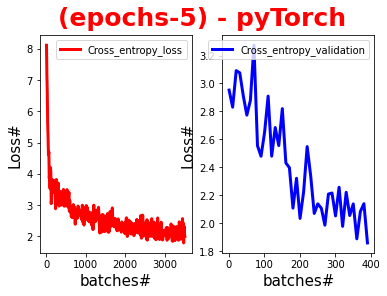

In [13]:
#(a) 1st Trainning process results
cross_entropy_training_interval = Training_batch*epochs
cross_entropy_validation_interval = Validation_batch*epochs
running_loss = running_loss[::10]
running_loss_index = [i for i in range(1, cross_entropy_training_interval, 10)]
running_loss_validation = running_loss_validation[::10]
running_loss_validation_index = [i for i in range(1, cross_entropy_validation_interval, 10)]
print('Cross_entropy_lengths: ', len(running_loss), len(running_loss_validation))
print('running_loss_index: ', len(running_loss_index))
print('running_loss_validation_index: ', len(running_loss_validation_index))

####Plot the loss on training, validation set
plt.figure()
plt.suptitle('(epochs-{}) - pyTorch'.format(epochs), fontsize=25, 
                color='r', fontweight='bold')     ## giving title on top of all subplots

plt.subplot(121)
plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='Cross_entropy_loss')
plt.legend(loc='best', fontsize=10)
plt.xlabel('batches#', fontsize=15)
plt.ylabel('Loss#', fontsize=15)

plt.subplot(122)
plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='Cross_entropy_validation')
plt.legend(loc='best', fontsize=10)
plt.xlabel('batches#', fontsize=15)
plt.ylabel('Loss#', fontsize=15)


plt.show()

(b) 2nd Trainning Method


In [14]:
!pip install -U d2l
from d2l import torch as d2l

In [19]:
#(a) 2nd Trainning Method
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_validation(net, train_iter, valid_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['Training loss', 'Training accuracy', 'Validation accuracy'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        valid_acc = evaluate_accuracy_gpu(net, valid_iter)
        animator.add(epoch + 1, (None, None, valid_acc))
    print(f'Loss {train_l:.3f}, Training accuracy {train_acc:.3f}, '
          f'Validation accuracy {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

Loss 1.960, Training accuracy 0.281, Validation accuracy 0.100
83.2 examples/sec on cpu


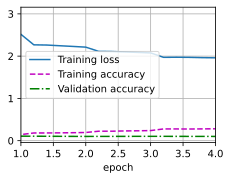

In [20]:
#(b) Define 2nd training method
lr, num_epochs = 0.0001, 4
train_validation(model, train_loader, val_loader, num_epochs, lr, d2l.try_gpu())

### (3) Evaluate the model and report performance using the test dataset

In [21]:
test_acc = evaluate_accuracy_gpu(model, test_loader)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.100
